# Partition function zeros via Wang-Landau 

In [2]:
import numpy as np, matplotlib.pyplot as plt
from time import time

In [3]:
def plot_dos_prob_e(model, temperatures):
    fig,ax = plt.subplots(1,2, figsize=(12, 5))
    
    e_range = model.energy_range/(2*model.L**2)

    ax[0].plot(e_range, model.dos)
    ax[0].set_xlabel('Energy per spin')
    ax[0].set_ylabel('log(Density of States)')
    ax[0].set_title(f'Density of States for 2D Ising Model (L={model.L})')

    for t in temperatures:
        prob_energy = model.calculate_prob_energy(t)
        ax[1].plot(e_range, prob_energy)
    ax[1].set_xlabel('Energy per spin')
    ax[1].set_ylabel('Prob(Energy)')
    ax[1].set_title(f'Energy Distribtuion for 2D Ising Model (L={model.L})')

    plt.show()

In [4]:
class Wang_Landau_2DIsing:
    # Code works only for H =0 
    def __init__(self, L, J=1):
        self.L = L
        self.J = J
        self.lattice = np.random.choice([-1, 1], size=(L, L))
        self.energy_range = self.E_list_gen()
        self.mag_range = np.arange(-L**2,L**2+1,2)
        #self.dos = np.zeros_like(self.energy_range, dtype=float)
        self.dos = np.zeros((L**2-1,L**2+1), dtype=float)
        self.histogram = np.zeros_like(self.dos, dtype=int)
        self.logf = 1
        self.total_energy = self.calculate_energy()
        self.total_mag = np.sum(self.lattice)
    
    def E_list_gen(self):
        ''' Generates list of energies for even L '''
        if self.L % 2 != 0:
            raise ValueError("This list generation only works for even side lengths")

        E_list=[-2*self.L**2 + 4*k for k in range(0,self.L**2+1)]
        E_list.pop(1)
        E_list.pop(-2)
        E_list=np.array(E_list)  # number of energy states = N-1

        return E_list
        
    def calculate_energy(self):
        energy = 0
        for i in range(self.L):
            for j in range(self.L):
                energy += -self.J * self.lattice[i, j] * (
                    self.lattice[(i+1)%self.L, j] + 
                    self.lattice[i, (j+1)%self.L] )
        return energy
    
    def flip_spin(self):
        i, j = np.random.randint(0, self.L, 2)
        delta_E = 2 * self.J * self.lattice[i, j] * (
            self.lattice[(i+1)%self.L, j] + 
            self.lattice[(i-1)%self.L, j] + 
            self.lattice[i, (j+1)%self.L] + 
            self.lattice[i, (j-1)%self.L] )
        return i, j, delta_E
    
    def calculate_prob_energy(self, T=1):
        partition_function = np.sum([ np.exp(g-e/T) for g,e in zip(self.dos, self.energy_range) ])
        return [ 1/partition_function*np.exp(g-e/T) for g,e in zip(self.dos, self.energy_range) ]


    def run_zero_h(self, logf_min = 1e-8, flatness_criterion = .8, N_sweeps = 1e2):
        # Surprsingly, checking every iteration is faster for L=8, haven't checked other sizes...
        self.dos = np.zeros_like(self.energy_range, dtype=float)
        self.histogram = np.zeros_like(self.energy_range, dtype=int)
        
        index1 = np.argwhere( self.energy_range == self.total_energy)[0,0]
        while self.logf > logf_min:
            iteration = 0
            self.histogram.fill(0)
            while np.min(self.histogram) <= flatness_criterion * np.mean(self.histogram):
                for s in range(int(N_sweeps*self.L**2)):
                    i, j, delta_E = self.flip_spin()
                    new_energy = self.total_energy + delta_E
                    index2 = np.argwhere( self.energy_range == new_energy)[0,0]

                    if (np.random.random() < np.exp(self.dos[index1] - self.dos[index2])):
                        self.lattice[i, j] *= -1
                        self.total_energy = new_energy
                        index1 = index2
                    else:
                        index1 = index1

                    self.dos[index1] += self.logf
                    self.histogram[index1] += 1
                    iteration += 1
                
            #print(f"ln(f) = {self.logf}", "and sweeps = ", iteration//self.L**2)
            self.logf *= 1/2
        
        #self.dos -= self.dos.min()
        self.dos -= (self.dos[0]-np.log(2))
        return self.energy_range, self.dos

Computation time =  25.17529010772705


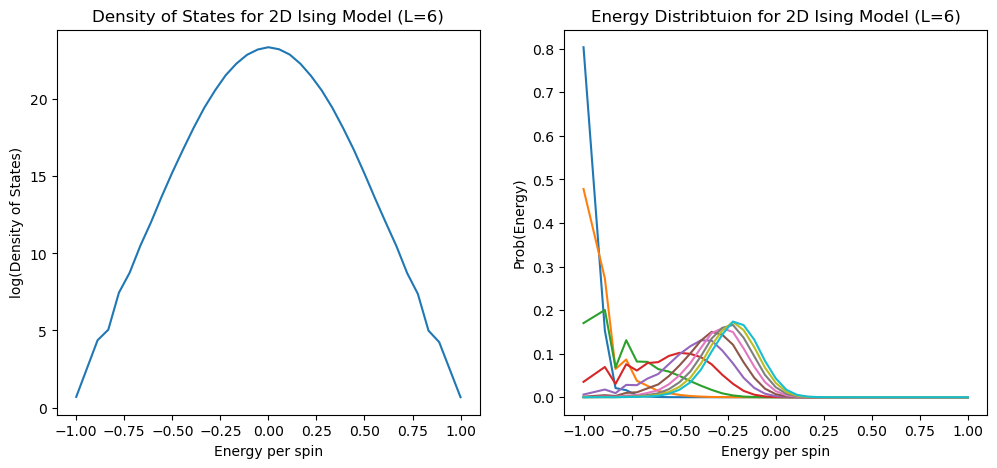

In [9]:
# Run the simulation
L = 6
model = Wang_Landau_2DIsing(L)
t0 = time()
energy_range, dos = model.run_zero_h()
print("Computation time = ", time()-t0)

temperatures = np.linspace(1.5,5,10)
plot_dos_prob_e(model,temperatures)

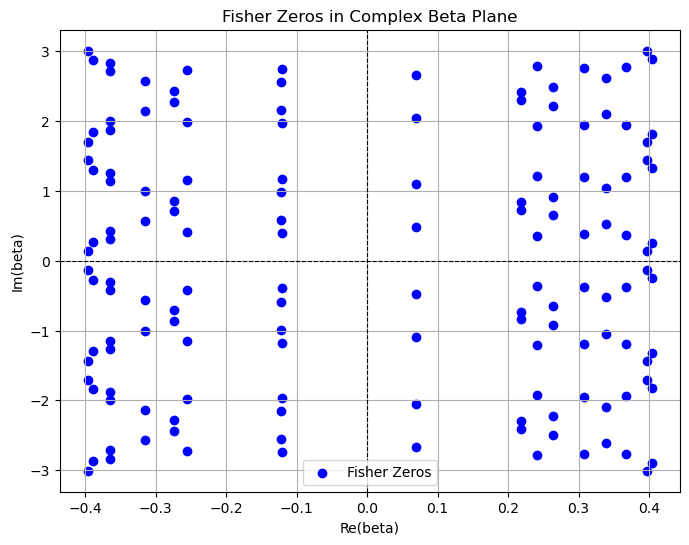

In [16]:
g_E = np.exp(dos)

# Normalize energy levels to start from zero
min_energy = int(np.min(energy_range))
normalized_energy_range = energy_range - min_energy

# Construct Z(beta): Polynomial in z with coefficients from g(E)
coefficients_length = int(normalized_energy_range[-1]) + 1
coefficients = np.zeros(coefficients_length)

for i, E in enumerate(normalized_energy_range):
    coefficients[int(E)] += g_E[i]

# Find roots of Z(z) where z corresponds to exp(-beta)
roots_z = np.roots(coefficients)

# Convert roots into beta values: beta corresponds to ln(z)
roots_beta_real = -np.log(np.abs(roots_z))
roots_beta_imaginary = np.angle(roots_z)

# Plot Fisher zeros in terms of beta in the complex plane
plt.figure(figsize=(8, 6))
plt.scatter(roots_beta_real, roots_beta_imaginary, color='blue', label="Fisher Zeros")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel("Re(beta)")
plt.ylabel("Im(beta)")
plt.title("Fisher Zeros in Complex Beta Plane")
plt.legend()
plt.grid()
plt.show()


## Perplexity code

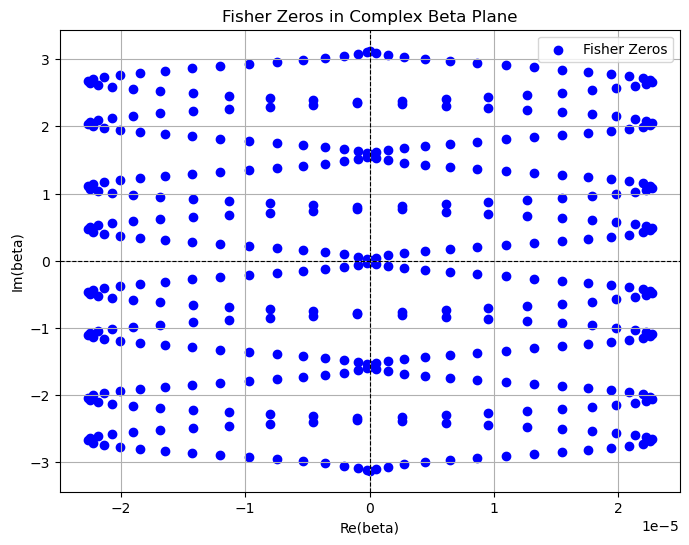

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 10  # Lattice size (LxL)
N = L * L  # Total number of spins
J = 1  # Coupling constant

# Energy levels and magnetization levels
energy_levels = np.arange(-2 * J * N, 2 * J * N + 4, 4)  # Discrete energy levels
magnetization_levels = np.arange(-N, N + 2, 2)  # Discrete magnetization levels

# Initialize density of states g(E, M)
g = np.zeros((len(energy_levels), len(magnetization_levels)))
histogram = np.zeros_like(g)

# Initialize spin lattice randomly
spins = np.random.choice([-1, 1], size=(L, L))

# Helper functions
def calculate_energy(spins):
    """Calculate total energy of the lattice."""
    energy = -J * sum(
        spins[i, j] * (spins[(i + 1) % L, j] + spins[i, (j + 1) % L])
        for i in range(L)
        for j in range(L)
    )
    return energy

def calculate_magnetization(spins):
    """Calculate total magnetization of the lattice."""
    return np.sum(spins)

def index_mapping(value, array):
    """Map a value to its index in an array."""
    return np.argmin(np.abs(array - value))

# Wang-Landau algorithm
f_factor = np.exp(1.0)
flatness_criterion = 0.8

while f_factor > 1e-8:
    histogram.fill(0)
    
    while True:
        # Randomly select a spin and flip it
        i, j = np.random.randint(0, L), np.random.randint(0, L)
        spins[i, j] *= -1
        
        # Calculate new energy and magnetization
        E_new = calculate_energy(spins)
        M_new = calculate_magnetization(spins)
        
        # Map to indices
        E_idx = index_mapping(E_new, energy_levels)
        M_idx = index_mapping(M_new, magnetization_levels)
        
        # Acceptance criterion
        if np.random.rand() < min(1.0, np.exp(g[E_idx, M_idx] - g[E_idx, M_idx])):
            pass  # Accept move
        else:
            spins[i, j] *= -1  # Reject move
        
        # Update DOS and histogram
        g[E_idx, M_idx] += f_factor
        histogram[E_idx, M_idx] += 1
        
        # Check histogram flatness
        if np.min(histogram[histogram > 0]) > flatness_criterion * np.mean(histogram[histogram > 0]):
            break
    
    f_factor /= 2.0

# Marginalize over magnetization to get g(E)
g_E = np.sum(np.exp(g), axis=1)

# Normalize energy levels to start from zero
min_energy = int(np.min(energy_levels))
normalized_energy_levels = energy_levels - min_energy

# Construct Z(beta): Polynomial in z with coefficients from g(E)
coefficients_length = int(normalized_energy_levels[-1]) + 1
coefficients = np.zeros(coefficients_length)

for i, E in enumerate(normalized_energy_levels):
    coefficients[int(E)] += g_E[i]

# Find roots of Z(z) where z corresponds to exp(-beta)
roots_z = np.roots(coefficients)

# Convert roots into beta values: beta corresponds to ln(z)
roots_beta_real = -np.log(np.abs(roots_z))
roots_beta_imaginary = np.angle(roots_z)

# Plot Fisher zeros in terms of beta in the complex plane
plt.figure(figsize=(8, 6))
plt.scatter(roots_beta_real, roots_beta_imaginary, color='blue', label="Fisher Zeros")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel("Re(beta)")
plt.ylabel("Im(beta)")
plt.title("Fisher Zeros in Complex Beta Plane")
plt.legend()
plt.grid()
plt.show()


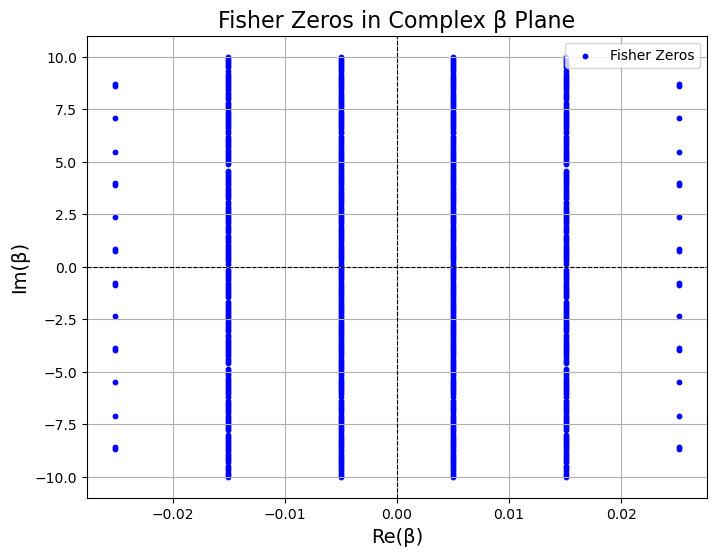

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 10  # Lattice size (LxL)
N = L * L  # Total number of spins
J = 1  # Coupling constant

# Energy levels (mock example; replace with actual Wang-Landau results)
energy_levels = np.arange(-2 * J * N, 2 * J * N + 4, 4)  # Discrete energy levels

# Define a grid in the complex beta plane
beta_real = np.linspace(-1, 1, 200)  # Real part of beta
beta_imaginary = np.linspace(-10, 10, 200)  # Imaginary part of beta
beta_real_grid, beta_imag_grid = np.meshgrid(beta_real, beta_imaginary)
beta_grid = beta_real_grid + 1j * beta_imag_grid

# Compute Z(beta) on the grid
Z_beta = np.zeros_like(beta_grid, dtype=np.complex128)

for i, E in enumerate(energy_levels):
    Z_beta += g_E[i] * np.exp(-beta_grid * E)

# Compute magnitude of Z(beta)
Z_magnitude = np.abs(Z_beta)

# Identify zeros numerically (where |Z(beta)| is close to zero)
threshold = np.percentile(Z_magnitude.flatten(), q=2)  # Adjust threshold if needed
zeros_real = beta_real_grid[np.where(Z_magnitude < threshold)]
zeros_imaginary = beta_imag_grid[np.where(Z_magnitude < threshold)]

# Plot Fisher zeros in the complex beta plane
plt.figure(figsize=(8, 6))
plt.scatter(zeros_real, zeros_imaginary, color='blue', s=10, label="Fisher Zeros")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel("Re(β)", fontsize=14)
plt.ylabel("Im(β)", fontsize=14)
plt.title("Fisher Zeros in Complex β Plane", fontsize=16)
plt.legend()
plt.grid()
plt.show()
